# **Proyecto 4x4 YPF - Primer pilar Vaca Muerta**

En esta etapa del proyecto 4x4, se aplicaron técnicas de Machine Learning no supervisado con el objetivo de explorar patrones ocultos en los datos energéticos sin necesidad de contar con una variable objetivo definida. El análisis se centró en identificar agrupamientos naturales entre las variables de producción de petróleo y  producción de gas de YPF en Vaca Muerta. Esto permitió observar cómo se comportan los distintos años en función de estos indicadores clave, y detectar posibles trayectorias de desarrollo o períodos atípicos en el cumplimiento del plan.

## **Kohonen SOM**

### Red neuronal no supervisada que proyecta datos de alta dimensión en un espacio bidimensional

### ¿Qué es un Mapa Autoorganizado de Kohonen (SOM)?

El SOM, propuesto por Teuvo Kohonen en los años 80, es un modelo de red neuronal no supervisada diseñado para reducir la dimensionalidad de datos complejos, descubrir patrones y visualizarlos en 2D, conservando la estructura topológica (es decir, manteniendo la cercanía entre puntos similares del espacio original).

Claves del SOM:

* No supervisado: No requiere etiquetas de salida.

* Topología preservada: Puntos similares en el espacio de entrada terminan cerca en el mapa 2D.

* Autoorganización: Ajusta sus pesos automáticamente para adaptarse a los datos.



MiniSom es una implementación liviana y eficiente de Mapas Autoorganizados de Kohonen (SOM) en Python, ideal para análisis no supervisado.

In [ ]:

!pip install minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=c230c110e45ae4584dfd9e3d88ff66b61d0ff4a1063dd18995b7948ee94d008d
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [ ]:
# Librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom


In [ ]:
# cargamos csv

import pandas as pd
df = pd.read_csv('/content/prod_encoded_df (1).csv')

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 2.7990229304413297


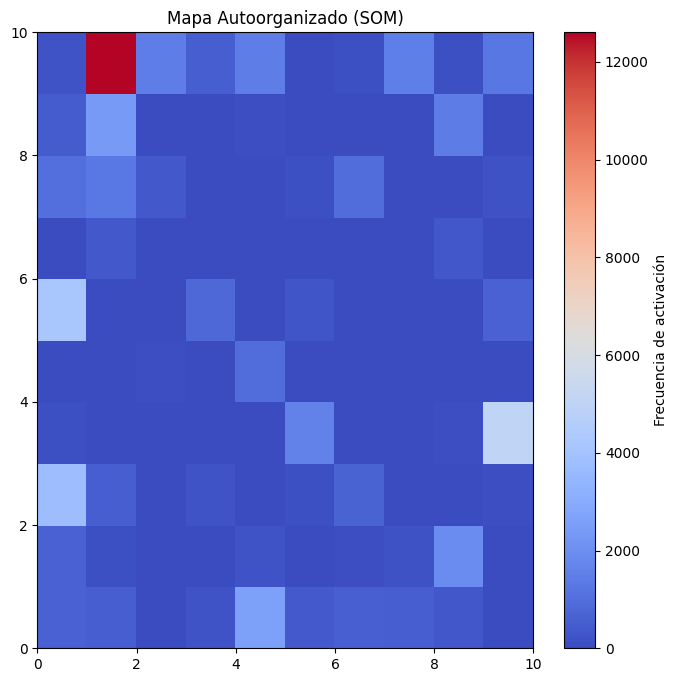

In [ ]:
import pandas as pd
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Cargar los datos
df = pd.read_csv('prod_encoded_df (1).csv')

# 2. Escalar los datos (SOM es sensible a escalas)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# 3. Definir y entrenar el SOM
som_grid_x, som_grid_y = 10, 10  # tamaño del mapa
som = MiniSom(som_grid_x, som_grid_y, data_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data_scaled)
som.train(data_scaled, num_iteration=1000, verbose=True)

# 4. Visualizar el SOM
plt.figure(figsize=(8, 8))
frequencies = som.activation_response(data_scaled)
plt.pcolor(frequencies.T, cmap='coolwarm')  # Mapa de calor
plt.colorbar(label='Frecuencia de activación')
plt.title('Mapa Autoorganizado (SOM)')
plt.show()


¿Qué nos permite ver el SOM?

* Cada celda del mapa representa un grupo latente de observaciones similares.

* Las zonas más "activadas" muestran dónde se agrupan más registros similares.

* El SOM detectó que gran parte de los registros son muy similares y pertenecen a un grupo dominante (la celda roja).

* Las otras celdas más claras representan subgrupos más pequeños, es decir, patrones minoritarios.

### Asignar a cada fila su grupo SOM (posición X,Y)

In [ ]:
# Asignar cada observación a una celda del SOM
win_map = [som.winner(x) for x in data_scaled]

# Agregarlo como columna al DataFrame original
df['som_node'] = win_map

# Podés separar en columnas X e Y si querés
df['som_x'] = df['som_node'].apply(lambda x: x[0])
df['som_y'] = df['som_node'].apply(lambda x: x[1])


### Analizar características por grupo SOM

In [ ]:
# Ver cuántas observaciones cayeron en cada celda SOM
conteo_por_celda = df.groupby('som_node').size().reset_index(name='cantidad')

# Ver características promedio por grupo SOM
promedios = df.groupby('som_node').mean(numeric_only=True)

# Mostrar algunos resultados
print(promedios.head())


          Tipo de pozo_Gasífero  Tipo de pozo_Inyección de Agua  \
som_node                                                          
(0, 0)                  0.00000                        0.000000   
(0, 1)                  0.00165                        0.000000   
(0, 2)                  0.00000                        0.004867   
(0, 3)                  1.00000                        0.000000   
(0, 4)                  1.00000                        0.000000   

          Tipo de pozo_Otro tipo  Tipo de pozo_Petrolífero  \
som_node                                                     
(0, 0)                  0.000000                  1.000000   
(0, 1)                  0.000000                  0.998350   
(0, 2)                  0.004327                  0.990806   
(0, 3)                  0.000000                  0.000000   
(0, 4)                  0.000000                  0.000000   

          Tipo de pozo_Sumidero  Tipo de recurso_NO CONVENCIONAL  \
som_node                   

Entonces un Mapa Autoorganizado (SOM) permite:

1. Descubrir patrones o grupos latentes. Agrupa observaciones similares según sus variables (que ya están codificadas). No le da etiquetas ni objetivos.

2. Proyectar datos de alta dimensión en un espacio 2D
Esto permite visualizar y entender si hay:

Grupos grandes (concentraciones)

Subgrupos raros o extremos

Posibles segmentos naturales en tus datos

###  Agrupar con K-Means sobre los centroides del SOM

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Obtener pesos (vectores de características) de cada neurona del SOM
weights = som.get_weights().reshape(-1, data_scaled.shape[1])

# Elegir cuántos clusters querés (ejemplo: 4)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(weights)

# Asignar cluster a cada observación según su celda SOM
node_cluster_map = kmeans.labels_.reshape(som_grid_x, som_grid_y)
df['cluster'] = df['som_node'].apply(lambda x: node_cluster_map[x[0], x[1]])


<Axes: xlabel='cluster', ylabel='count'>

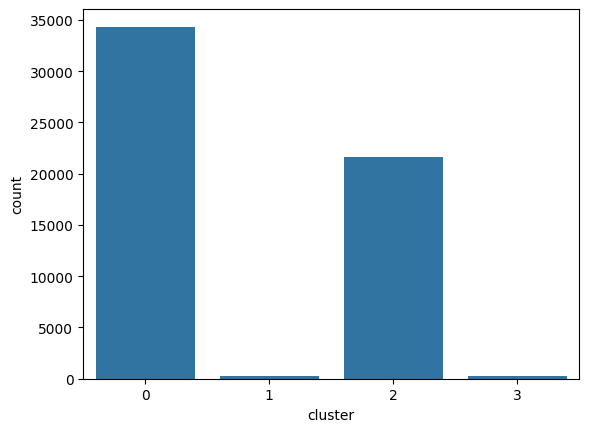

In [ ]:
import seaborn as sns
sns.countplot(data=df, x='cluster')


Interpretación del gráfico:

* Cluster 0: Más de 33.000 registros

Este es el grupo dominante. La gran mayoría de los datos tienen características similares y caen en este grupo.

* Cluster 2: Aproximadamente 22.000 registros

Es el segundo grupo más común. Puede representar un patrón diferente pero también frecuente.

* Cluster 1 y 3: Muy pocos registros

Probablemente contienen outliers o casos raros y extremos, con combinaciones de variables poco frecuentes.

In [ ]:
# Agrupar por cluster y ver el promedio de las variables
df.groupby('cluster').mean(numeric_only=True).T


cluster,0,1,2,3
Tipo de pozo_Gasífero,0.324463,0.067824,0.000000,0.856069
Tipo de pozo_Inyección de Agua,0.000000,0.000624,0.000000,0.000000
Tipo de pozo_Otro tipo,0.589901,0.057536,1.000000,0.134500
Tipo de pozo_Petrolífero,0.000000,0.874015,0.000000,0.009431
Tipo de pozo_Sumidero,0.085636,0.000000,0.000000,0.000000
Tipo de recurso_NO CONVENCIONAL,1.000000,1.000000,1.000000,1.000000
Subtipo de recurso_SHALE,1.000000,0.987155,1.000000,0.048212
Subtipo de recurso_TIGHT,0.000000,0.012845,0.000000,0.951788
Area de permiso de concesion_AGUADA DE LA ARENA,0.000000,0.024739,0.000000,0.000000
Area de permiso de concesion_AGUADA DEL CHAÑAR,0.001365,0.013916,0.000000,0.000000


In [ ]:
# Mostrar el promedio de Producción de Petróleo y Gas por cluster
df.groupby('cluster')[['Produccion de Petroleo', 'Produccion de Gas']].mean()


,Produccion de Petroleo,Produccion de Gas
cluster,,
0,1.199591,516.965200
1,781.454105,331.034849
2,0.000000,0.000000
3,25.655706,333.975390


### Conclusión:
Este análisis permite descubrir segmentos naturales en las operaciones, aunque no tenga etiquetas.

### MÉTRICAS PARA EVALUAR UN SOM

### Error Cuadrático Medio (Quantization Error)
Mide la distancia promedio entre cada dato y su neurona ganadora (la más parecida).

In [ ]:
quantization_error = som.quantization_error(data_scaled)
print(f"Quantization Error: {quantization_error}")


Quantization Error: 2.7990229304413297


Interpretación: El SOM podría ser muy chico o necesita más iteraciones.

### Topographic Error

Evalúa cuántos datos fueron mal asignados en términos de topología (es decir, si cayeron lejos de neuronas similares).

In [ ]:
topographic_error = som.topographic_error(data_scaled)
print(f"Topographic Error: {topographic_error}")


Topographic Error: 0.09505831472225176


Interpretación: Significa que el 90.5% de los datos fueron correctamente representados topológicamente.

### Mapa de U-Matrix (Unified Distance Matrix)

Visualización que muestra las distancias entre las neuronas vecinas.
Las zonas oscuras indican fronteras entre grupos bien separados.

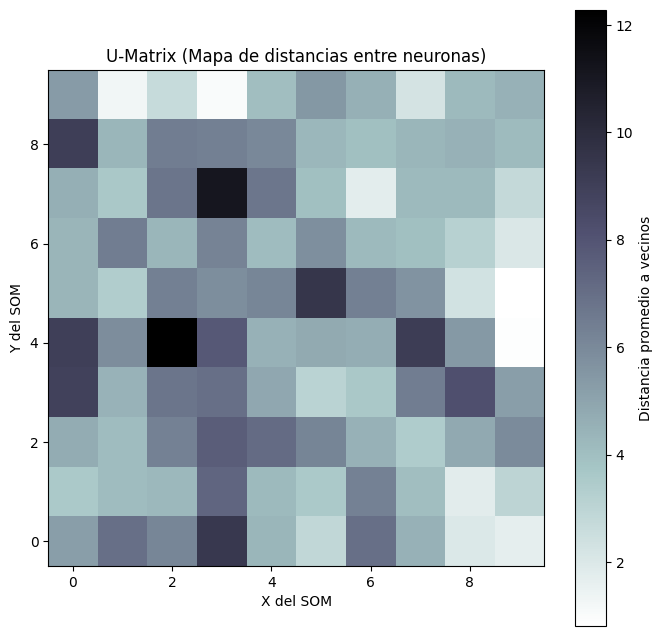

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Obtenemos los pesos de cada neurona del SOM
weights = som.get_weights()  # Shape: (x, y, n_features)
u_matrix = np.zeros((som_grid_x, som_grid_y))

# Calcular la distancia promedio a los vecinos
for i in range(som_grid_x):
    for j in range(som_grid_y):
        neighbors = []
        if i > 0:
            neighbors.append(weights[i-1, j])
        if i < som_grid_x - 1:
            neighbors.append(weights[i+1, j])
        if j > 0:
            neighbors.append(weights[i, j-1])
        if j < som_grid_y - 1:
            neighbors.append(weights[i, j+1])

        # Promedio de distancias a los vecinos
        dists = [np.linalg.norm(weights[i, j] - neighbor) for neighbor in neighbors]
        u_matrix[i, j] = np.mean(dists)

# Graficar la U-Matrix
plt.figure(figsize=(8, 8))
plt.imshow(u_matrix.T, cmap='bone_r', origin='lower')
plt.colorbar(label='Distancia promedio a vecinos')
plt.title('U-Matrix (Mapa de distancias entre neuronas)')
plt.xlabel('X del SOM')
plt.ylabel('Y del SOM')
plt.show()



* Se destacan 2–3 zonas negras (más de 10–12 de distancia):

Esas son fronteras entre clusters bien diferenciados.

Sugiere que el SOM encontró patrones contrastantes en esas regiones del espacio.

* La mayoría del mapa está en tonos medios (4–8):

Indica transiciones suaves o subgrupos relacionados.

### Silhouette Score

Mide qué tan bien definidos están los clusters.



In [ ]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(data_scaled, df['cluster'])
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.24954630209539808


Interpretación:

Es un valor positivo y cercano a 0.25, lo que indica que los clusters tienen cierta estructura, pero no están claramente separados.

Hay cierta superposición o cercanía entre algunos clusters, lo cual es común en datos reales complejos.

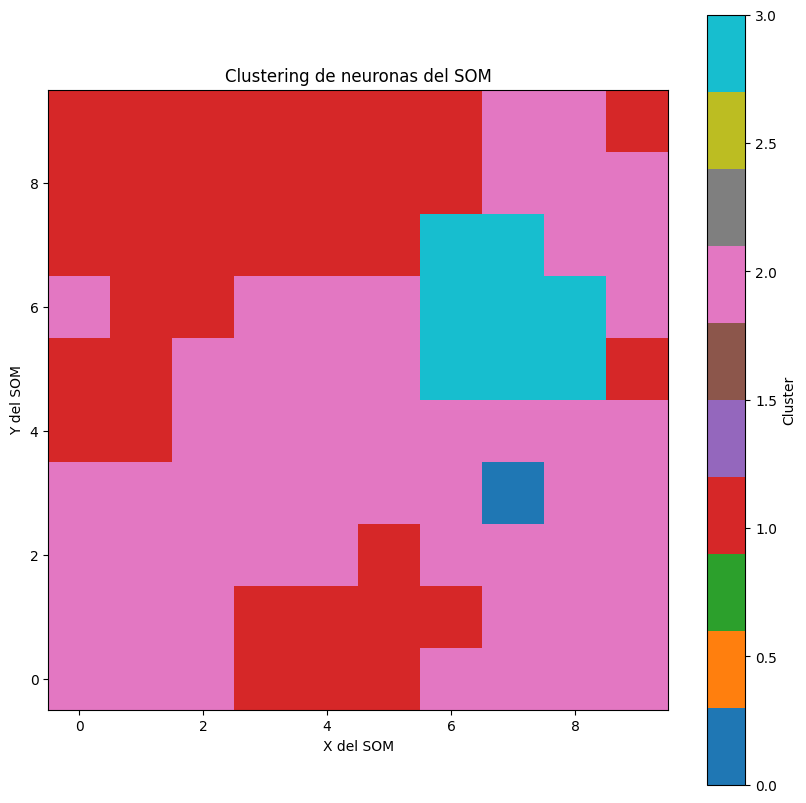

In [ ]:
# Recolectar los vectores de pesos de cada neurona
codebook_vectors = som.get_weights().reshape(-1, data_scaled.shape[1])

# Aplicar KMeans a los vectores del SOM
from sklearn.cluster import KMeans
k = 4  # Elegí el número estimado de clusters según tu U-Matrix
kmeans = KMeans(n_clusters=k, random_state=42).fit(codebook_vectors)

# Mapa con clusters por neurona
plt.figure(figsize=(10, 10))
plt.title('Clustering de neuronas del SOM')
plt.imshow(kmeans.labels_.reshape(som_grid_x, som_grid_y), cmap='tab10', origin='lower')
plt.colorbar(label='Cluster')
plt.xlabel('X del SOM')
plt.ylabel('Y del SOM')
plt.show()


* Zonas de color compacto:

Como el área roja (Cluster 1) o fucsia (Cluster 2).

Significan grupos estables y grandes de datos similares.

Tipología común en la producción.

* Zonas más pequeñas o aisladas:

Como los bloques turquesa o azul oscuro.

Indican comportamientos más raros, outliers o segmentos especiales.

* Bordes irregulares entre colores:

Marcan transiciones bruscas entre patrones → pueden ser fronteras útiles para análisis operativo, comercial o de eficiencia.

Zona del mapa	Posible interpretación

Cluster 1	Operaciones de alta producción de petróleo.

Cluster 2	Operaciones de alta producción de gas.

Cluster 0	Casos atípicos o marginales (poca o nula producción).

Fronteras	Cambios de estrategia, tipos de pozo, técnicas o problemas.

###  Asociar cada neurona a su cluster (de KMeans)

In [ ]:
# Mapear cada neurona (por coordenada) a un cluster
neuron_clusters = kmeans.labels_.reshape(som_grid_x, som_grid_y)

# Crear una columna en tu dataframe con la neurona (BMU) donde cae cada dato
df['bmu'] = [som.winner(x) for x in data_scaled]

# Asignar el cluster de la neurona BMU a cada observación
df['neuron_cluster'] = df['bmu'].apply(lambda x: neuron_clusters[x[0], x[1]])


### Analizar variables promedio por cluster del SOM

In [ ]:
# Agrupar por cluster asignado y calcular SUMA (en vez de promedio)
resumen_clusters = df.groupby('neuron_cluster')[['Produccion de Petroleo', 'Produccion de Gas']].sum().round(2)

# Agregar la cantidad de observaciones por cluster
resumen_clusters['Cantidad de observaciones'] = df['neuron_cluster'].value_counts().sort_index()

# Mostrar tabla
print(resumen_clusters)


                Produccion de Petroleo  Produccion de Gas  \
neuron_cluster                                              
0                                  0.0                0.0   
1                             499270.0          6558774.0   
2                           26282619.0         12609760.0   
3                              11437.0           102122.0   

                Cantidad de observaciones  
neuron_cluster                             
0                                      27  
1                                   19127  
2                                   36184  
3                                    1080  


 CONCLUSIÓN


Hay un patrón claro de cuatro tipos de operación o comportamiento.

El Cluster 2 concentra la mayoría de observaciones (36 mil) y representa alta productividad en ambos recursos.

El Cluster 0 puede indicar casos anómalos o sin actividad.

El resto está entre rendimiento bajo o parcial.